In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
from PIL import Image, ImageFilter, ImageEnhance
import datetime
import os

In [ ]:
#We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
#In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

In [ ]:
#Generator

In [ ]:
#This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size, is_train=False, augmention=False, debug=False):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
        num_batches = (len(t) + batch_size - 1) // batch_size  # calculates number of batches
        for batch in range(num_batches):  # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # x is the number of images, (y, z) is the size
            batch_labels = np.zeros((batch_size, 5))  # batch_labels is the one-hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20, 5))
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(os.path.join(source_path, folder_str.split(';')[0]))  # read all images in the folder

                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and np.random.randint(0, 2) == 1:
                    aug_type = np.random.randint(0, 5)  # randomly selecting augmentation type

                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = Image.open(os.path.join(source_path, folder_str.strip().split(';')[0], imgs[item])).convert('RGB')
                    image = np.array(image).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx + 1)
                        plt.imshow(image.astype('uint8'))

                    # Crop the images and resize them
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[crop_start:crop_end, :]

                    resized_im = Image.fromarray(image.astype('uint8')).resize((y, z))

                    if aug_type is not None:
                        if aug_type == 0:  # Edge Enhancement
                            resized_im = resized_im.filter(ImageFilter.EDGE_ENHANCE)
                        elif aug_type == 1:  # Adding Gaussian Blur
                            resized_im = resized_im.filter(ImageFilter.GaussianBlur(1))
                        elif aug_type == 2:  # Enhancing Image Detail
                            resized_im = resized_im.filter(ImageFilter.DETAIL)
                        elif aug_type == 3:  # Sharpening Image
                            resized_im = resized_im.filter(ImageFilter.SHARPEN)
                        elif aug_type == 4:  # Brightness Enhancement
                            resized_im = ImageEnhance.Brightness(resized_im).enhance(1.5)

                    resized_im = np.array(resized_im)

                    if debug:
                        plt.subplot(2, x, idx + x + 1)
                        plt.imshow(resized_im)

                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255  # normalize and feed in the image
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255  # normalize and feed in the image
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255  # normalize and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # you yield the batch_data and the batch_labels

In [ ]:
#Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


Source path =  /home/datasets/Project_data/train ; batch size = 1


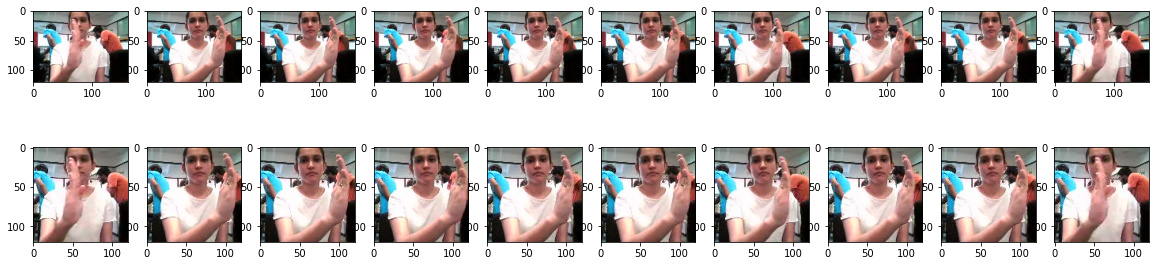

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)

In [ ]:
#Model

In [ ]:
#Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#Conv3D

In [9]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

2024-10-02 13:56:42.411265: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-02 13:56:42.411334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [ ]:
#Experiment - 3

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='SAME'))  # Fixed padding
model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='SAME'))  # Fixed padding
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 4

In [13]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 5 & 6

In [14]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 7 & 8

In [15]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 9

In [16]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 10

In [17]:
# loss: 0.1388 - categorical_accuracy: 0.9539 - val_loss: 0.1661 - val_categorical_accuracy: 0.9297
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 11

In [ ]:
#TimeDistributed Conv2D + GRU

In [18]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 12

In [ ]:
#TimeDistributed Conv2D + GRU

In [19]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 13

In [ ]:
#TimeDistributed Conv2D + Dense

In [20]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(
     Conv2D(128, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Experiment - 14


In [ ]:
#TimeDistributed + ConvLSTM2D

In [23]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(BatchNormalization())
model.add(TimeDistributed(
     Conv2D(16, (3,3), activation='relu'))
 )
model.add(BatchNormalization())
model.add(
     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
 )
model.add(BatchNormalization())
model.add(TimeDistributed(
     Dense(64, activation='relu'))
 )
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Final Model

In [31]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [33]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.01)  # Correct way
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 10, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_38 (Bat  (None, 10, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_39 (Bat  (None, 10, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 114, 114, 8)     

In [ ]:
#Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [34]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [35]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=50,  # Set epochs to 50
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - 28s 1s/step - loss: 1.4193 - categorical_accuracy: 0.3452 - val_loss: 1.3624 - val_categorical_accuracy: 0.3281 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - 25s 1s/step - loss: 1.2702 - categorical_accuracy: 0.4271 - val_loss: 1.6203 - val_categorical_accuracy: 0.1406 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - 25s 1s/step - loss: 1.2292 - categorical_accuracy: 0.4301 - val_loss: 1.3381 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 4/50
21/21 [==============================] - 24s 1s/step - loss: 1.1999 - categorical_accuracy: 0.4807 - val_loss: 1.3723 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 5/50
21/21 [==============================] - 25s 1s/step - loss: 1.1520 - categorical_accuracy: 0.5045 - val_loss: 1.4559 - val_categorical_accuracy: 0.1328 - lr: 0.0100
Epoch 6/50
21/21 [==============================

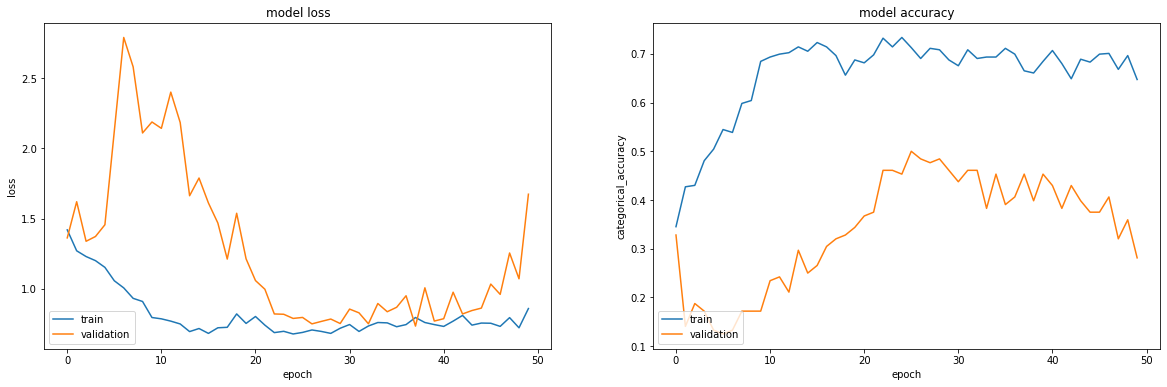

In [38]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')